# Import data from ned.nl
In the Energy-Charts API (and ENTSOE), the Dutch data is badly reported, a lot of production is classified as "Others".
Fortunately, ned.nl, the Dutch TSO, has an API we can use to extract better data.
This notebook shows how to, with a lot of help from [ElectricityMaps](https://github.com/electricitymaps/electricitymaps-contrib/blob/8eb159be3bb8823c9648d554ace1b9bd1e8f6b30/electricitymap/contrib/parsers/NED.py#L4).

In [2]:
import pandas as pd
import requests
from datetime import datetime, timedelta, timezone
from enum import Enum

In [ ]:
# Load your API key
API_KEY = open("../data/ned_api_key.txt").read()

In [ ]:
# Build the header object
headers = {"X-AUTH-TOKEN": API_KEY, "accept": "application/json"}

In [233]:
# We will not use all of them, only electricity production types
# ...and the API imposes a limit of 20 types anyway
# From https://ned.nl/datacatalogus

types_to_use = [1,
                2,
                # 17,
                18,
                19,
                20,
                21,
                # 22,
                25,
                26,
                35,
                51,
                ]
len(types_to_use)

10

In [249]:
# Retrieve types from the API type collection
# "types" are the various electricity generation sources
types = [requests.get(f"https://api.ned.nl/v1/types/{t}", headers=headers).json() for t in types_to_use]

In [255]:
type_names = pd.DataFrame(types).set_index("id")["name"].to_dict()

In [259]:
type_names

{1: 'Wind',
 2: 'Solar',
 18: 'FossilGasPower',
 19: 'FossilHardCoal',
 20: 'Nuclear',
 21: 'WastePower',
 25: 'BiomassPower',
 26: 'OtherPower',
 35: 'WKK Total',
 51: 'WindOffshoreC'}

In [260]:
class NedActivity(Enum):
    PRODUCTION = 1
    CONSUMPTION = 2


class NedGranularity(Enum):
    TEN_MINUTES = 3
    FIFTEEN_MINUTES = 4
    HOURLY = 5 # This is what we want, but it's good to know other options exist
    DAILY = 6
    MONTHLY = 7
    YEARLY = 8


class NedGranularityTimezone(Enum):
    UTC = 0
    LOCAL = 1


class NedClassification(Enum):
    FORECAST = 1
    MEASURED = 2


class NedPoint(Enum):
    NETHERLANDS = 0


In [261]:
# API URL
URL = "https://api.ned.nl/v1/utilizations"

In [262]:
# If we want to do (short-term) forecast at some point
forecast = False

In [263]:
# Date in datetime format
valid_from_after = datetime(2025, 10, 20)
valid_from_before = datetime(2025, 10, 22)
time_span = (valid_from_before - valid_from_after).days * 24

In [264]:
# API can only do 200 items per page max
n_pages = len(types_to_use) * time_span // 200 + 1

dfs = []

for page in range(1, n_pages+1):

    params = {
        "page": page,
        "itemsPerPage": 200,
        "point": NedPoint.NETHERLANDS.value,
        "type[]": types_to_use,
        "granularity": NedGranularity.HOURLY.value,
        "granularitytimezone": NedGranularityTimezone.UTC.value,
        "classification": NedClassification.MEASURED.value,
        "activity": NedActivity.PRODUCTION.value,
        "validfrom[after]": valid_from_after.date().isoformat(),
        "validfrom[before]": valid_from_before.date().isoformat()
    }

    r = requests.get(URL, params=params, headers=headers)
    dfs.append(pd.DataFrame.from_dict(r.json()))

In [265]:
hourly_data = pd.concat(dfs)
hourly_data.shape

(490, 15)

In [266]:
hourly_data.tail()

,id,point,type,granularity,granularitytimezone,activity,classification,capacity,volume,percentage,emission,emissionfactor,validfrom,validto,lastupdate
85,71069112234,/v1/points/0,/v1/types/35,/v1/granularities/5,/v1/granularity_time_zones/0,/v1/activities/1,/v1/classifications/2,897871,897871,0.000000,267565,0.298,2025-10-22T00:00:00+00:00,2025-10-22T01:00:00+00:00,2025-10-23T10:17:31+00:00
86,71069103873,/v1/points/0,/v1/types/19,/v1/granularities/5,/v1/granularity_time_zones/0,/v1/activities/1,/v1/classifications/2,492976,492976,0.122875,393392,0.798,2025-10-22T00:00:00+00:00,2025-10-22T01:00:00+00:00,2025-10-23T10:17:05+00:00
87,71069134445,/v1/points/0,/v1/types/2,/v1/granularities/5,/v1/granularity_time_zones/0,/v1/activities/1,/v1/classifications/2,0,0,0.000000,0,0.000,2025-10-22T00:00:00+00:00,2025-10-22T01:00:00+00:00,2025-10-24T11:52:50+00:00
88,71069103626,/v1/points/0,/v1/types/18,/v1/granularities/5,/v1/granularity_time_zones/0,/v1/activities/1,/v1/classifications/2,1511750,1511750,0.000000,598653,0.396,2025-10-22T00:00:00+00:00,2025-10-22T01:00:00+00:00,2025-10-23T10:17:04+00:00
89,71069155925,/v1/points/0,/v1/types/51,/v1/granularities/5,/v1/granularity_time_zones/0,/v1/activities/1,/v1/classifications/2,2872751,2872751,0.690898,0,0.000,2025-10-22T00:00:00+00:00,2025-10-22T01:00:00+00:00,2025-10-24T11:54:09+00:00


In [267]:
# Map to human-readable types
hourly_data["type_name"] = pd.to_numeric(hourly_data["type"].str.split("/", expand=True).iloc[:,-1]).map(type_names)

In [268]:
hourly_data[(hourly_data["type_name"]=="Solar") & (hourly_data["validfrom"]=="2025-10-20T10:00:00+00:00")]

,id,point,type,granularity,granularitytimezone,activity,classification,capacity,volume,percentage,emission,emissionfactor,validfrom,validto,lastupdate,type_name
106,71052099388,/v1/points/0,/v1/types/2,/v1/granularities/5,/v1/granularity_time_zones/0,/v1/activities/1,/v1/classifications/2,6275259,6275259,0.239214,0,0.0,2025-10-20T10:00:00+00:00,2025-10-20T11:00:00+00:00,2025-10-22T23:52:55+00:00,Solar


In [269]:
hourly_data.drop_duplicates(inplace=True)

In [270]:
hourly_data[["type_name", "volume", "validfrom"]].set_index(["type_name", "validfrom"])["volume"]

type_name       validfrom                
Wind            2025-10-20T00:00:00+00:00    3569594
BiomassPower    2025-10-20T00:00:00+00:00     131394
FossilGasPower  2025-10-20T00:00:00+00:00     739000
WindOffshoreC   2025-10-20T00:00:00+00:00    4378751
WKK Total       2025-10-20T00:00:00+00:00     760778
                                              ...   
                2025-10-22T00:00:00+00:00     897871
FossilHardCoal  2025-10-22T00:00:00+00:00     492976
Solar           2025-10-22T00:00:00+00:00          0
FossilGasPower  2025-10-22T00:00:00+00:00    1511750
WindOffshoreC   2025-10-22T00:00:00+00:00    2872751
Name: volume, Length: 490, dtype: int64

<Axes: xlabel='validfrom'>

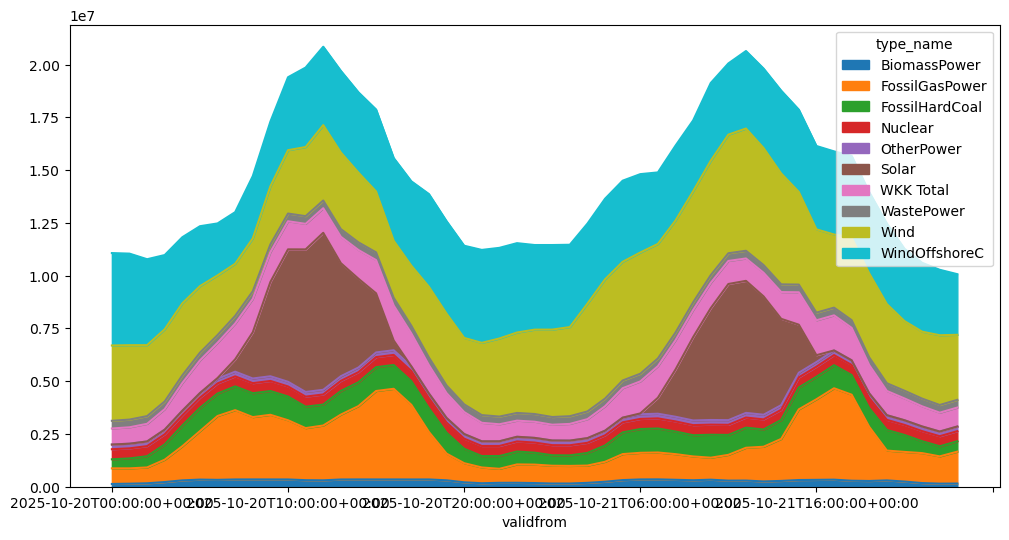

In [271]:
# Check the data makes sense on a graph
to_plot = hourly_data[["type_name", "volume", "validfrom"]].set_index(["type_name", "validfrom"])["volume"].unstack("type_name")
to_plot.plot.area(stacked=True, figsize=(12,6))

<Axes: xlabel='validfrom'>

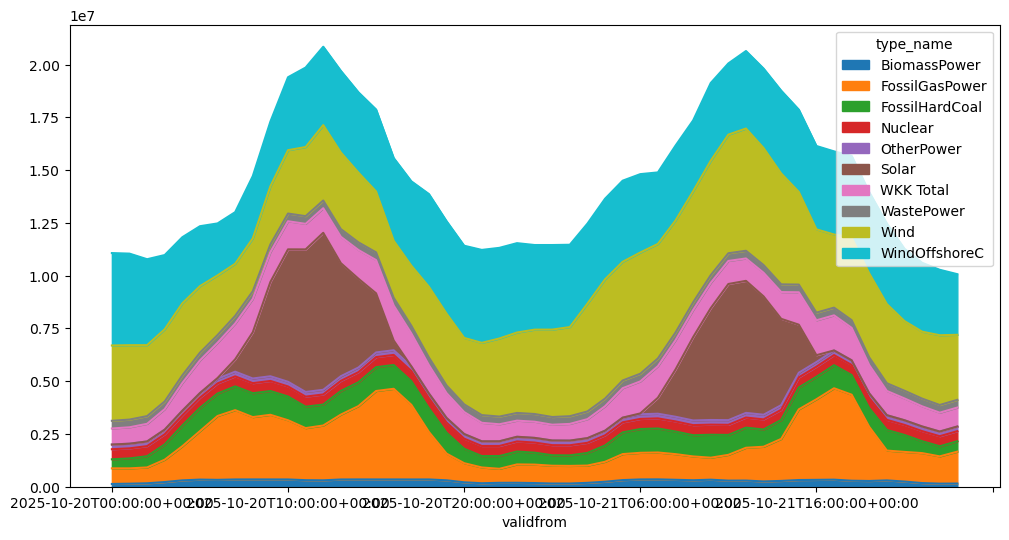

In [272]:
# Some data is missing... let's interpolate
to_plot.interpolate().plot.area(stacked=True, figsize=(12,6))

In [273]:
pd.DataFrame(type_names.values()).to_clipboard()

In [274]:
[type_names[t] for t in types_to_use]

['Wind',
 'Solar',
 'FossilGasPower',
 'FossilHardCoal',
 'Nuclear',
 'WastePower',
 'BiomassPower',
 'OtherPower',
 'WKK Total',
 'WindOffshoreC']

In [225]:
requests.get("https://api.ned.nl/v1/types/35", headers=headers).json()

{'id': 35, 'identifier': 35, 'name': 'WKK Total', 'nameshort': 'WKKT'}

In [232]:
requests.get("https://api.ned.nl/v1/types/60", headers=headers).json()

{'type': 'https://tools.ietf.org/html/rfc2616#section-10',
 'title': 'An error occurred',
 'detail': 'Not Found'}